In [22]:
from recordtype import recordtype
import pathlib
import os
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

import dadrah.kfold_pipeline.kfold_poly_fitting as kpofi
import dadrah.kfold_pipeline.kfold_prediction as kpred
import dadrah.kfold_pipeline.kfold_string_constants as kstco
import dadrah.kfold_pipeline.kfold_util as kutil
import dadrah.util.data_processing as dapr
import dadrah.selection.anomaly_score_strategy as ansc

In [12]:
Parameters = recordtype('Parameters','qr_run_n, kfold_n, quantiles, qcd_sample_id, sig_sample_id, sig_xsec, score_strategy_id, read_n, layers_n, nodes_n, epochs, batch_sz, lr, env_run_n, binning, poly_run_n, poly_order')
params = Parameters(qr_run_n=401,
                        kfold_n=5,
                        quantiles=[0.3, 0.5, 0.7, 0.9],
                        qcd_sample_id='qcdSigAll', 
                        sig_sample_id='GtoWW35naReco',
                        sig_xsec=0,
                        score_strategy_id='rk5_05',
                        read_n=None,
                        layers_n=4,
                        nodes_n=5,
                        epochs=50,
                        batch_sz=32,
                        lr=1e-3,
                        env_run_n=0,
                        binning='dijet',
                        poly_run_n=0,
                        poly_order=11
                        )

In [40]:
def plot_multi_quantile_poly_cut(params, k, polynomials, x_shift, sample, score_strategy, feature_key='mJJ', title_suffix='', plot_name='multi_poly_cut', fig_dir=None, xlim=False):

    # Load CMS style sheet
    plt.style.use(hep.style.CMS)
    jet= plt.get_cmap('gnuplot')
    colors = iter(jet(np.linspace(0,1,6)))
    
    fig = plt.figure(figsize=(8, 8))
    x_min = np.min(sample[feature_key])
    x_max = np.max(sample[feature_key])
    an_score = score_strategy(sample)
    x_top = np.percentile(sample[feature_key], 99.999) if xlim else x_max
    x_range = ((x_min * 0.9,x_top), (np.min(an_score), np.percentile(an_score, 99.99)))
    plt.hist2d((sample[feature_key]), an_score, range=x_range, norm=(LogNorm()),bins=100)
    xs = np.arange(x_min, x_max, 0.001 * (x_max - x_min))
    for q in params.quantiles:
        polynomial = polynomials[q]
        plt.plot(xs, polynomial(xs-x_shift), '-', lw=2.5, label='Q '+str(int(q*100))+'%', color=next(colors))
    plt.ylabel('L1 \& L2 $> L_T$')
    plt.xlabel('$M_{jj}$ [GeV]')
    #plt.title('quantile cuts' + title_suffix)
    plt.colorbar()
    plt.legend(loc='best', title='quantile cuts')
    plt.draw()
    if fig_dir:
        fig.savefig(os.path.join(fig_dir, plot_name + '_fold'+ str(k) +'.pdf'), bbox_inches='tight')
    plt.show()
    plt.close(fig)


In [28]:
#****************************************#
#           read in polynomials
#****************************************#
polys_path = kstco.get_polynomials_full_file_path(params)
print('reading polynomials from ' + polys_path)
polynomials_folds, x_shift = dapr.read_polynomials_from_json(polys_path, params.quantiles, params.kfold_n)

reading polynomials from /eos/user/k/kiwoznia/data/QR_results/models/qr_run_401/env_run_0/poly_run_0/polynomials_run_0_envelope_run_0_qr_run_401_allQ_GtoWW35naReco_sigx0_ord11_allFolds.json


In [29]:
#****************************************#
#           read in all qcd data
#****************************************#

qcd_sample_parts = kutil.read_kfold_datasets(kstco.vae_out_dir_kfold_qcd, params.kfold_n, read_n=params.read_n)

reading qcd_sqrtshatTeV_13TeV_PU40_NEW_fold1.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold2.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold3.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold4.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold5.h5from /eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_5fold_signalregion_parts


In [30]:
#*****************************************

score_strategy = ansc.an_score_strategy_dict[params.score_strategy_id]

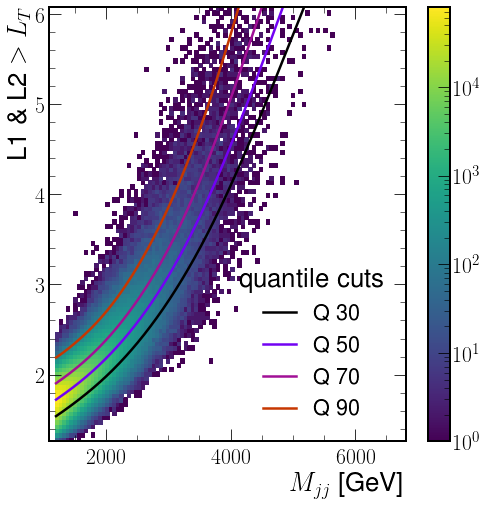

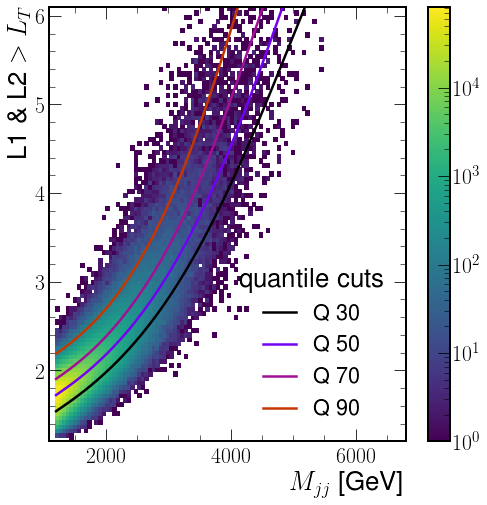

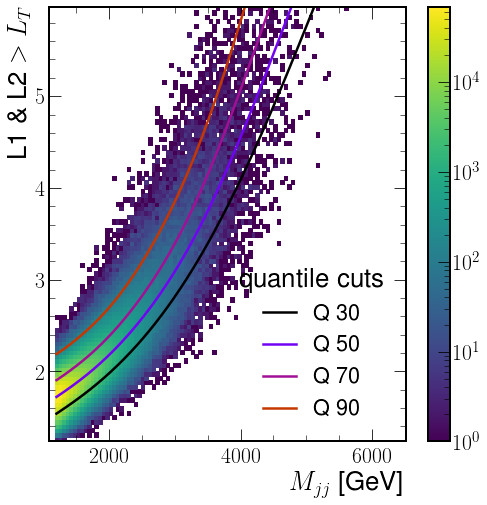

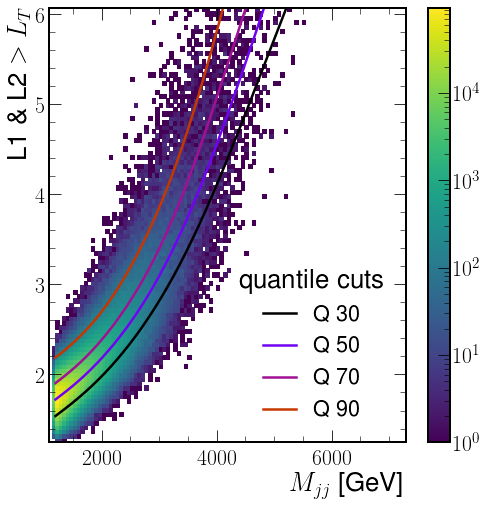

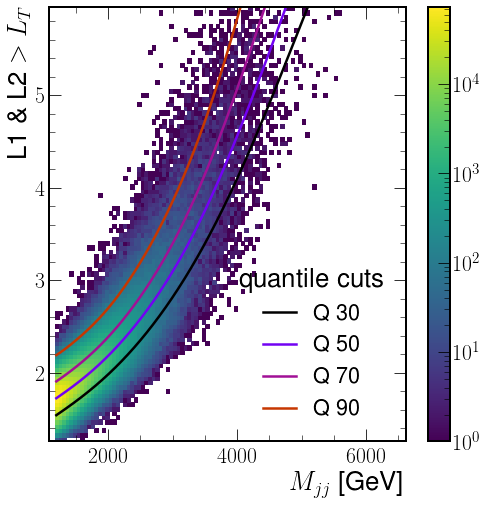

In [41]:
#***************************************#
#               plot
#***************************************#
for k, sample in zip(range(1, params.kfold_n+1), qcd_sample_parts):
    plot_multi_quantile_poly_cut(params, k, polynomials_folds['fold_{}'.format(k)], x_shift, sample, score_strategy)